**Proyecto - Elementos térmicos unidimensionales lineales en coordenadas cilíndricas**

In [1]:
# Importación de módulos de cálculos
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.4f}'.format}) #Opciones de impresión de numpy

**Pre-procesamiento**

In [2]:
# Datos del problema

# Tubería de cobre
kcu = 385                   #Conductividad térmica del cobre [W/m-K]
hcu = 5 * 10**-3            #Espesor de la tubería [m]
dext_cu = 20 * 10**-3       #Diámetro externo de la tubería [m]
dint_cu = dext_cu - 2*hcu   #Diámetro interno de la tubería [m]
r1 = dint_cu/2              #Radio interno de la tubería [m]
r2 = dext_cu/2              #Radio externo de la tubería [m]

# Fluido de trabajo: agua helada
Tint = 5 + 273              #Temperatura (K) del fluido que se asume igual a la de la pared interna de la tubería

# Aislante
kais = 0.0055               #Conductividad térmica del aislate [W/m-K]
hais = 10 * 10**-3          #Espesor del aislante [m]
dext_ais = dext_cu + 2*hais #Diámetro externo del aislate [m]
r3 = dext_ais/2             #Radio externo del aislante

#Condiciones ambientales
h = 5                       #Coeficiente convectivo [W/m-k]
Tamb = 35 + 273             #Temperatura (K) del ambiente externo

#Vector de conductividades
k = np.array([kcu, kais])

In [3]:
# Tabla de conectividades
# Elemento / nodo 1 / nodo 2

Con = np.array([
        [0, 0, 1],
        [1, 1, 2]
    ])

# Tabla de coordenadas nodales
# Nodo / r

Coord = np.array([
        [0, r1],
        [1, r2],
        [2, r3]
    ])

# Tabla de grados de libertad

GDL = np.array([
        [0, 1],     #Elemento 0
        [1, 2],     #Elemento 1
    ])

nnodos = 3
ngdl_nodo = 1
nDOF_total = nnodos * ngdl_nodo

In [4]:
# Función de matriz de conductividad térmica elemental

def Kt_elem(Coord, Con, elemento, k):
    ri = Coord[elemento, 1]
    rj = Coord[elemento+1, 1]
    kt_e = (np.pi*k[elemento]/(2*(rj-ri))) * np.array([
                                                    [2*ri + 2*rj, -(2*ri + 2*rj)],
                                                    [-(2*ri + 2*rj), 2*ri + 2*rj]
                                                    ])
    return kt_e

In [5]:
# Función de matriz de convectividad

def kh_elem(Coord, Con, elemento, h):
    rj = Coord[elemento+1, 1]
    kh_e = 2*np.pi*rj * np.array([
                             [0, 0],
                             [0, h]
                             ])
    return kh_e

In [6]:
# Función de calor por convectividad

def Qh_elem(Coord, Con, elemento, h, Tamb):
    rj = Coord[elemento+1, 1]
    Qh_e = np.array([
            [0, 2*np.pi*rj*h*Tamb]
        ])
    return Qh_e

In [7]:
# Ensamblaje de la matriz de conductividades térmicas Kt

K = np.zeros([nDOF_total, nDOF_total])

for nelem in range(0, 2):
    Kt = Kt_elem(Coord, Con, nelem, k)
    for a in range(0, 2):
        rw = GDL[nelem, a]
        for b in range(0, 2):
            cl = GDL[nelem, b]
            K[rw, cl] = K[rw, cl] + Kt[a, b]
            
# Incorporación de la convectividad del elemento externo

Kh = kh_elem(Coord, Con, 1, h)
K[1:3, 1:3] = K[1:3, 1:3] + Kh

In [8]:
# Vector de calor 

Q = np.zeros([nDOF_total])
    
Qh = Qh_elem(Coord, Con, 1, h, Tamb)

Q[1:] = Q[1:] + Qh

**Resolución y Post-procesamiento**

In [9]:
# Aplicación de condición de borde por penalización
kc = np.max(np.max(np.abs(K))) * 10**6
Km = np.array(K)
Km[0,0] += kc
Qm = np.array(Q)
Qm[0] += kc*Tint

# Resolución del sistema
T = np.linalg.solve(Km, Qm)
print("Distribución de Temperatura [°C]:")
print(T - 273)
print()

# Cálculo del flujo de calor (por unidad de longitud)
A_ext = 2*np.pi*r3
Q_flujo = A_ext*h*(Tamb-T[2])
print("Flujo de calor por unidad de longitud en la tubería [W/m]:")
print("%0.4f" % Q_flujo)

np.allclose(np.dot(Km, T), Qm)    #Verificación de la resolución del sistema

Distribución de Temperatura [°C]:
[ 5.0000  5.0004  32.7137]

Flujo de calor por unidad de longitud en la tubería [W/m]:
1.4366


True

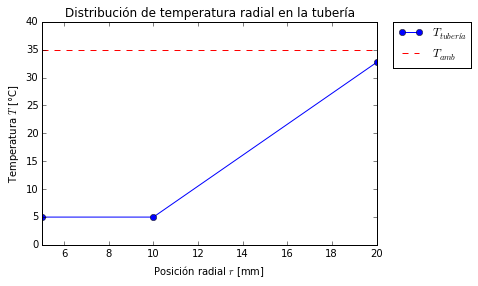

In [10]:
#Distribución de temperatura
r = np.array([r1, r2, r3])
Temp_amb = np.array([35, 35, 35])
plt.plot(r*10**3, T-273, "o-b", label="$T_{tubería}$")
plt.plot(r*10**3, Temp_amb, "--r", label="$T_{amb}$")
plt.xlim(r1*10**3, r3*10**3)
plt.ylim(0, 40)
plt.xlabel("Posición radial $r$ [mm]")
plt.ylabel("Temperatura $T$ [°C]")
plt.title("Distribución de temperatura radial en la tubería")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Análisis de convergencia**

Distribución de Temperatura [°C]:
[ 5.0000  5.0000  5.0000  5.0000  5.0000  5.0001  5.0001  5.0001  5.0001
  5.0001  5.0001  5.0001  5.0001  5.0001  5.0001  5.0002  5.0002  5.0002
  5.0002  5.0002  5.0002  5.0002  5.0002  5.0002  5.0002  5.0002  5.0002
  5.0002  5.0003  5.0003  5.0003  5.0003  5.0003  5.0003  5.0003  5.0003
  5.0003  5.0003  5.0003  5.0003  5.0003  5.0003  5.0003  5.0004  5.0004
  5.0004  5.0004  5.0004  5.0004  5.0004  5.0004  5.7944  6.5731  7.3369
  8.0864  8.8221  9.5447  10.2544  10.9517  11.6372  12.3111  12.9739
  13.6260  14.2675  14.8990  15.5207  16.1329  16.7359  17.3300  17.9154
  18.4923  19.0611  19.6219  20.1750  20.7206  21.2589  21.7900  22.3141
  22.8315  23.3424  23.8468  24.3449  24.8369  25.3230  25.8032  26.2777
  26.7467  27.2103  27.6686  28.1217  28.5697  29.0128  29.4510  29.8845
  30.3134  30.7377  31.1576  31.5732  31.9844  32.3915  32.7945]

Flujo de calor por unidad de longitud en la tubería [W/m]:
1.3857


/home/josue/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


False

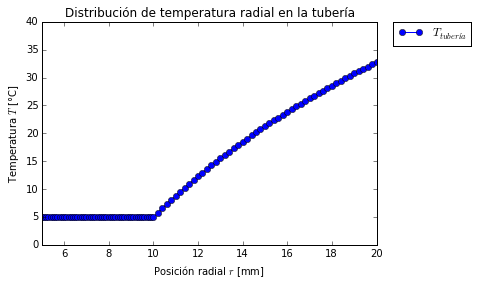

In [13]:
elem_total = 100            #Número de elementos del sistema
div = elem_total/2        #Número para discretización por elemento base
long_cu = (r2-r1)/ div    #Espesor de cada elemento en la tubería de cobre
long_ais = (r3-r2) / div  #Espesor de cada elemento en el aislante

ee = int(2*div)
em = int(ee/2)

#Vector de conductividades
k = np.zeros([ee])
for n in range(0, em):
    k[n] = kcu
for n in range(em, ee):
    k[n] = kais

# Tabla de conectividades
# Elemento / nodo 1 / nodo 2
Con = np.zeros([ee, 3])
for n in range(0, ee):
    Con[n,:] = [n, n, n+1]

# Tabla de coordenadas nodales
# Nodo / r
Coord = np.zeros([ee+1, 2])
Coord[0,:] = [0, r1]
for n in range(1, em+1):
    Coord[n,:] = [n, Coord[n-1,1]+long_cu]
    for n in range(em+1, ee+1):
        Coord[n,:] = [n, Coord[n-1,1]+long_ais]

# Tabla de grados de libertad
GDL = np.zeros([ee, 2])
for n in range(0, ee):
    GDL[n,:] = [n, n+1]

nnodos = ee + 1
ngdl_nodo = 1
nDOF_total = nnodos * ngdl_nodo

# Ensamblaje de la matriz de conductividades térmicas Kt

K = np.zeros([nDOF_total, nDOF_total])

for nelem in range(0, elem_total):
    Kt = Kt_elem(Coord, Con, nelem, k)
    for a in range(0, 2):
        rw = GDL[nelem, a]
        for b in range(0, 2):
            cl = GDL[nelem, b]
            K[rw, cl] = K[rw, cl] + Kt[a, b]

# Incorporación de la convectividad del elemento externo

Kh = kh_elem(Coord, Con, elem_total-1, h)
K[nDOF_total-2:nDOF_total, nDOF_total-2:nDOF_total] = K[nDOF_total-2:nDOF_total, nDOF_total-2:nDOF_total] + Kh

# Vector de calor 

Q = np.zeros([nDOF_total])

Qh = Qh_elem(Coord, Con, elem_total-1, h, Tamb)

Q[nDOF_total-2:] = Q[nDOF_total-2:] + Qh

# Aplicación de condición de borde por penalización
kc = np.max(np.max(np.abs(K))) * 10**6
Km = np.array(K)
Km[0,0] += kc
Qm = np.array(Q)
Qm[0] += kc*Tint

# Resolución del sistema
T = np.linalg.solve(Km, Qm)
print("Distribución de Temperatura [°C]:")
print(T - 273)
print()

# Cálculo del flujo de calor (por unidad de longitud)
A_ext = 2*np.pi*r3
Q_flujo = A_ext*h*(Tamb-T[nDOF_total-1])
print("Flujo de calor por unidad de longitud en la tubería [W/m]:")
print("%0.4f" % Q_flujo)

#Distribución de temperatura
r = np.zeros([nnodos])
for n in range(0, nnodos):
    r[n] = Coord[n, 1]
plt.plot(r*10**3, T-273, "o-b", label="$T_{tubería}$")
plt.xlim(5, 20)
plt.ylim(0, 40)
plt.xlabel("Posición radial $r$ [mm]")
plt.ylabel("Temperatura $T$ [°C]")
plt.title("Distribución de temperatura radial en la tubería")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

np.allclose(np.dot(Km, T), Qm)    #Verificación de la resolución del sistema